In [2]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
from pandas import read_csv
from pandas import DataFrame
import numpy as np
import pandas as pd

df=read_csv('강남구.csv', header=0, dtype=({'date':str}))
df.drop(['location'], axis=1, inplace=True)


col_list=df.columns
for each in col_list:
    df[each].fillna(0, inplace=True)
    
df['datetime']=pd.to_datetime(df['date'])+pd.TimedeltaIndex(df['time'], unit='H')
df.drop(['date', 'time'], axis=1, inplace=True)
df.set_index('datetime', inplace=True)

df['windx']=df['wind_speed']*np.cos(df['wind_direction'])
df['windy']=-df['wind_speed']*np.sin(df['wind_direction'])
df.drop(['wind_direction', 'wind_speed'], axis=1, inplace=True)

#some extrme maybe dust which condider not the real concentration
#change to average of the column
df.loc[df['pm10']>400, ['pm10']]=df.pm10.mean()
df.loc[df['pm25']>180, ['pm10']]=df.pm25.mean()
df.loc[df['temperature']>45, ['temperature']]=df.temperature.mean()
df.loc[df['temperature']<-25, ['temperature']]=df.temperature.mean()
df.loc[df['rain']<0, ['rain']]=df.rain.mean()

In [4]:
from pytz import all_timezones
import pytz

utc_seoul=pytz.timezone('Asia/Seoul')
df.index=df.index.tz_localize(tz='Asia/Seoul')

In [5]:
target_names=['pm10','pm25']

#station defined as the number of observation stations in each cities
stations=1
shift_days=1
#cause have 39 sub area in Seoul of this dataset
shift_steps=shift_days*stations

df_targets=df[target_names].shift(-shift_steps)

x_data=df.values[0:-shift_steps:]
y_data=df_targets.values[:-shift_steps]
print(x_data.shape)
print(y_data.shape)

#seperate the data set
num_data = len(x_data)
train_split = 0.7
num_train = int(train_split * num_data)
num_val = int(((1-train_split)*0.80)*num_data)
num_test = num_data-num_train-num_val

#in case some NaN exist in the numpy array
loc=np.isnan(x_data)
x_data[loc]=0

#seperate data 
#input signals for training and test
x_train = x_data[:num_train,0:]
x_val = x_data[num_train:num_train+num_val,0:]
x_test = x_data[num_train+num_val:,0:]
print("seperated x dataset:" ,x_train.shape,x_val.shape, x_test.shape)

#output signals for trainnig and test
y_train = y_data[0:num_train]
y_val = y_data[num_train:num_train+num_val]
y_test = y_data[num_train+num_val:]
print("seperated y dataset:" ,y_train.shape, y_val.shape, y_test.shape)

print("traning days:",num_train//stations//24)
print("validation days:", num_val//stations//24)
print('test days:', num_test//stations//24)

#### import numpy as np
from sklearn.preprocessing import MinMaxScaler

#scale data 
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_val_scaled = x_scaler.fit_transform(x_val)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.fit_transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

(34895, 9)
(34895, 2)
seperated x dataset: (24426, 9) (8374, 9) (2095, 9)
seperated y dataset: (24426, 2) (8374, 2) (2095, 2)
traning days: 1017
validation days: 348
test days: 87
Min: -16.799999
Max: 369.0


In [6]:
#generate batch of shorter sequences picked at random from the training data

def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals. 
        x_shape = (batch_size, sequence_length, x_train_scaled.shape[1])
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, y_train_scaled.shape[1])
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length) 
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [7]:
#depended on your GPU
batch_size = 256
#one day 24*39
sequence_length = 24*stations

generator = batch_generator(batch_size=batch_size,sequence_length=sequence_length)
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(256, 24, 9)
(256, 24, 2)


In [8]:
validation_data = (np.expand_dims(x_val_scaled, axis=0),
                   np.expand_dims(y_val_scaled, axis=0))

test_data = (np.expand_dims(x_test_scaled, axis=0),
            np.expand_dims(y_test_scaled, axis=0))

In [9]:
!ls *.h5

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
from keras.models import load_model

cnn = load_model('CNN.h5')
gru = load_model('GRU.h5')
lstm=load_model('LSTM.h5')
hybrid = load_model('CNN_GRU.h5')
hybrid2= load_model('CNN_LSTM.h5')


Using TensorFlow backend.


In [11]:
from keras.utils import plot_model
plot_model(cnn, to_file='cnn1.png', show_layer_names=False, show_shapes=True)
plot_model(gru, to_file='gru1.png', show_layer_names=False, show_shapes=True)
plot_model(lstm, to_file='lstm1.png', show_layer_names=False, show_shapes=True)
plot_model(hybrid, to_file='hybrid1.png', show_layer_names=False, show_shapes=True)
plot_model(hybrid2, to_file='hybrid2.png', show_layer_names=False, show_shapes=True)

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [12]:
hybrid.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 128)         27776     
_________________________________________________________________
gru_1 (GRU)                  (None, None, 64)          37056     
_________________________________________________________________
dense_1 (Dense)              (None, None, 32)          2080      
_________________________________________________________________
dense_2 (Dense)              (None, None, 2)           66        
Total params: 66,978
Trainable params: 66,978
Non-trainable params: 0
_________________________________________________________________


In [13]:
hybrid2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 128)         27776     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
dense_1 (Dense)              (None, None, 32)          2080      
_________________________________________________________________
dense_2 (Dense)              (None, None, 2)           66        
Total params: 79,330
Trainable params: 79,330
Non-trainable params: 0
_________________________________________________________________


In [14]:
cnn.evaluate(x=test_data[0], y=test_data[1])

1/1 [==============================] - 4s 4s/step


[0.00028994426247663796, 0.8238663673400879]

In [15]:
gru.evaluate(x=test_data[0], y=test_data[1])

1/1 [==============================] - 2s 2s/step


[0.0016780196456238627, 0.8310262560844421]

In [16]:
lstm.evaluate(x=test_data[0], y=test_data[1])

1/1 [==============================] - 3s 3s/step


[0.0019303194712847471, 0.8353222012519836]

In [17]:
hybrid.evaluate(x=test_data[0], y=test_data[1])

1/1 [==============================] - 1s 1s/step


[9.747544390847906e-05, 0.9618138670921326]

In [18]:
hybrid2.evaluate(x=test_data[0], y=test_data[1])

1/1 [==============================] - 2s 2s/step


[1.9499364498187788e-05, 0.9670644402503967]

In [19]:
pred_cnn= cnn.predict(x=test_data[0])
pred_gru= gru.predict(x=test_data[0])
pred_lstm=lstm.predict(x=test_data[0])
pred_hybrid= hybrid.predict(x=test_data[0])
pred_hybrid2=hybrid2.predict(x=test_data[0])

In [20]:
print(pred_cnn.shape)
print(pred_gru.shape)
print(pred_lstm.shape)
print(pred_hybrid.shape)
print(pred_hybrid2.shape)

(1, 2095, 2)
(1, 2095, 2)
(1, 2095, 2)
(1, 2095, 2)
(1, 2095, 2)


In [21]:
#option 2 
#rescale by dataset source first and inverse back, then rescaled again for new model

cnn_hat=y_scaler.inverse_transform(pred_cnn[0])
gru_hat=y_scaler.inverse_transform(pred_gru[0])
lstm_hat=y_scaler.inverse_transform(pred_lstm[0])
hybrid_hat=y_scaler.inverse_transform(pred_hybrid[0])
hybrid2_hat=y_scaler.inverse_transform(pred_hybrid2[0])

In [22]:
#calculate RMSE and MAE
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

cnn_rmse_10=sqrt(mean_squared_error(y_test[:, 0], cnn_hat[:, 0]))
cnn_mae_10=mean_absolute_error(y_test[:, 0], cnn_hat[:, 0])

gru_rmse_10=sqrt(mean_squared_error(y_test[:, 0], gru_hat[:, 0]))
gru_mae_10=mean_absolute_error(y_test[:, 0], gru_hat[:, 0])

lstm_rmse_10=sqrt(mean_squared_error(y_test[:, 0], lstm_hat[:, 0]))
lstm_mae_10=mean_absolute_error(y_test[:, 0], lstm_hat[:, 0])

hybrid_rmse_10=sqrt(mean_squared_error(y_test[:, 0], hybrid_hat[:, 0]))
hybrid_mae_10=mean_absolute_error(y_test[:, 0], hybrid_hat[:, 0])

hybrid2_rmse_10=sqrt(mean_squared_error(y_test[:, 0], hybrid2_hat[:, 0]))
hybrid2_mae_10=mean_absolute_error(y_test[:, 0], hybrid2_hat[:, 0])
#############

cnn_rmse_25=sqrt(mean_squared_error(y_test[:, 1], cnn_hat[:, 1]))
cnn_mae_25=mean_absolute_error(y_test[:, 1], cnn_hat[:, 1])

gru_rmse_25=sqrt(mean_squared_error(y_test[:, 1], gru_hat[:, 1]))
gru_mae_25=mean_absolute_error(y_test[:, 1], gru_hat[:, 1])

lstm_rmse_25=sqrt(mean_squared_error(y_test[:, 1], lstm_hat[:, 1]))
lstm_mae_25=mean_absolute_error(y_test[:, 1], lstm_hat[:, 1])

hybrid_rmse_25=sqrt(mean_squared_error(y_test[:,1], hybrid_hat[:, 1]))
hybrid_mae_25=mean_absolute_error(y_test[:, 1], hybrid_hat[:, 1])

hybrid2_rmse_25=sqrt(mean_squared_error(y_test[:,1], hybrid2_hat[:, 1]))
hybrid2_mae_25=mean_absolute_error(y_test[:, 1], hybrid2_hat[:, 1])

###############

print('\n')
print('cnn_rmse_10:\t', cnn_rmse_10)
print('gru_rmse_10:\t', gru_rmse_10)
print('lstm_rmse_10:\t', lstm_rmse_10)
print('hybrid_rmse_10:\t', hybrid_rmse_10)
print('hybrid2_rmse_10:', hybrid2_rmse_10)

print('\n')
print('cnn_mae_10:\t', cnn_mae_10)
print('gru_mae_10:\t', gru_mae_10)
print('lstm_mae_10:\t', lstm_mae_10)
print('hybrid_mae_10:\t', hybrid_mae_10)
print('hybrid2_mae_10:\t', hybrid2_mae_10)

print('\n')
print('cnn_rmse_25:\t', cnn_rmse_25)
print('gru_rmse_25:\t', gru_rmse_25)
print('lstm_rmse_25:\t', lstm_rmse_25)
print('hybrid_rmse_25:\t', hybrid_rmse_25)
print('hybrid2_rmse_25:', hybrid2_rmse_25)

print('\n')
print('cnn_mae_25:\t', cnn_mae_25)
print('gru_mae_25:\t', gru_mae_25)
print('lstm_mae_25:\t', lstm_mae_25)
print('hybrid_mae_25:\t', hybrid_mae_25)
print('hybrid2_mae_25:\t', hybrid2_mae_25)



cnn_rmse_10:	 6.81316302579947
gru_rmse_10:	 9.865346446578311
lstm_rmse_10:	 10.66292621990432
hybrid_rmse_10:	 3.193386332862129
hybrid2_rmse_10: 0.9203149336773616


cnn_mae_10:	 5.526287115957401
gru_mae_10:	 6.307580704905253
lstm_mae_10:	 6.901562601854238
hybrid_mae_10:	 1.9438389370151237
hybrid2_mae_10:	 0.5559368447073889


cnn_rmse_25:	 1.1706450036620075
gru_rmse_25:	 6.650137492347662
lstm_rmse_25:	 7.106700465805632
hybrid_rmse_25:	 1.2674083572583377
hybrid2_rmse_25: 0.7576721666787949


cnn_mae_25:	 0.7428162057539515
gru_mae_25:	 4.687197146836784
lstm_mae_25:	 5.081090011346312
hybrid_mae_25:	 1.005932005436153
hybrid2_mae_25:	 0.5416936347443335


In [23]:
def pre_print(model ):
    #get the different time length predicting result
    day=7
    temp_size=day*stations*24
    
    model=model
    
    temp_x=x_test_scaled[:temp_size]
    temp_y=y_test_scaled[:temp_size]


    new=model.evaluate(x=np.expand_dims(temp_x, axis=0), y=np.expand_dims(temp_y, axis=0))
    print("loss and acc:", new)


    test_temp_0=test_data[0][:,:temp_size,:]
    test_temp_1=test_data[1][:,:temp_size,:]
    print(test_temp_1.shape)

    #calculate the predicting results
    from math import sqrt
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    #caution! test data include x_test_scaled and y_test_scaled
    yy_pred=model.predict(test_temp_0)

    yy_pred_rescaled=y_scaler.inverse_transform(yy_pred[0])
    yy_cap = y_scaler.inverse_transform(test_temp_1[0])

    mae_pm10=mean_absolute_error(yy_cap[:, 0],yy_pred_rescaled[:, 0])
    mae_pm25=mean_absolute_error(yy_cap[:, 1],yy_pred_rescaled[:, 1])

    rmse_pm10=sqrt(mean_squared_error(yy_cap[:,0], yy_pred_rescaled[:,0]))
    rmse_pm25=sqrt(mean_squared_error(yy_cap[:,1], yy_pred_rescaled[:,1]))

    print('rmse_pm10: %.3f'%rmse_pm10)
    print('mae_pm10:  %.3f'%mae_pm10)
    print('rmse_pm25: %.3f'%rmse_pm25)
    print('mae_pm25:  %.3f'%mae_pm25)

    #draw the concentration trends in limited length of time
    # combine the staions in the same city, use average  of stations to represent one time point 
    #(combine the stations in same time to one time point )

    sep_size=y_test.shape[0]//stations
    y_test_avg=np.zeros((sep_size,2))
    y_pred_rescaled_avg=np.zeros((sep_size,2))

    for i in range(sep_size):
        y_test_avg[i, 0]=np.mean(yy_cap[i*stations:stations*(i+1),0])
        y_test_avg[i, 1]=np.mean(yy_cap[i*stations:stations*(i+1),1])
        y_pred_rescaled_avg[i, 0]=np.mean(yy_pred_rescaled[i*stations:stations*(i+1),0])
        y_pred_rescaled_avg[i, 1]=np.mean(yy_pred_rescaled[i*stations:stations*(i+1),1])


    from matplotlib import pyplot as plt
    plt.figure( dpi=300)
    plt.plot(y_test_avg[:24*day,0], label='true')
    plt.plot(y_pred_rescaled_avg[:24*day,0], label='predict',linestyle='dashed')
    plt.ylabel('PM10 concentration')
    plt.xlabel('future hours')
    #p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
    plt.legend()
    plt.show()

    plt.figure(dpi=300)
    #plt.figure(figsize=(20, 10), dpi=300)
    plt.plot(y_test_avg[:24*day,1], label='true')
    plt.plot(y_pred_rescaled_avg[:24*day,1], label='predict',linestyle='dashed')
    plt.ylabel('PM2.5 concentration')
    plt.xlabel('future hours')
    #p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
    plt.legend()
    plt.show()
    plt.close('all')

In [24]:
pre_print(cnn)

1/1 [==============================] - 0s 70ms/step
loss and acc: [5.388099089032039e-05, 0.7678571343421936]
(1, 168, 2)
rmse_pm10: 2.648
mae_pm10:  2.243
rmse_pm25: 0.773
mae_pm25:  0.611


c:\users\tim\documents\predicting_models\prepare_for_journal\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\tim\documents\predicting_models\prepare_for_journal\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\tim\documents\predicting_models\prepare_for_journal\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


<Figure size 1920x1440 with 1 Axes>

<Figure size 1920x1440 with 1 Axes>

1/1 [==============================] - 0s 137ms/step
loss and acc: [0.0003270472807344049, 0.6309523582458496]
(1, 168, 2)
rmse_pm10: 4.204
mae_pm10:  3.360
rmse_pm25: 2.982
mae_pm25:  2.508


c:\users\tim\documents\predicting_models\prepare_for_journal\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\tim\documents\predicting_models\prepare_for_journal\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\tim\documents\predicting_models\prepare_for_journal\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


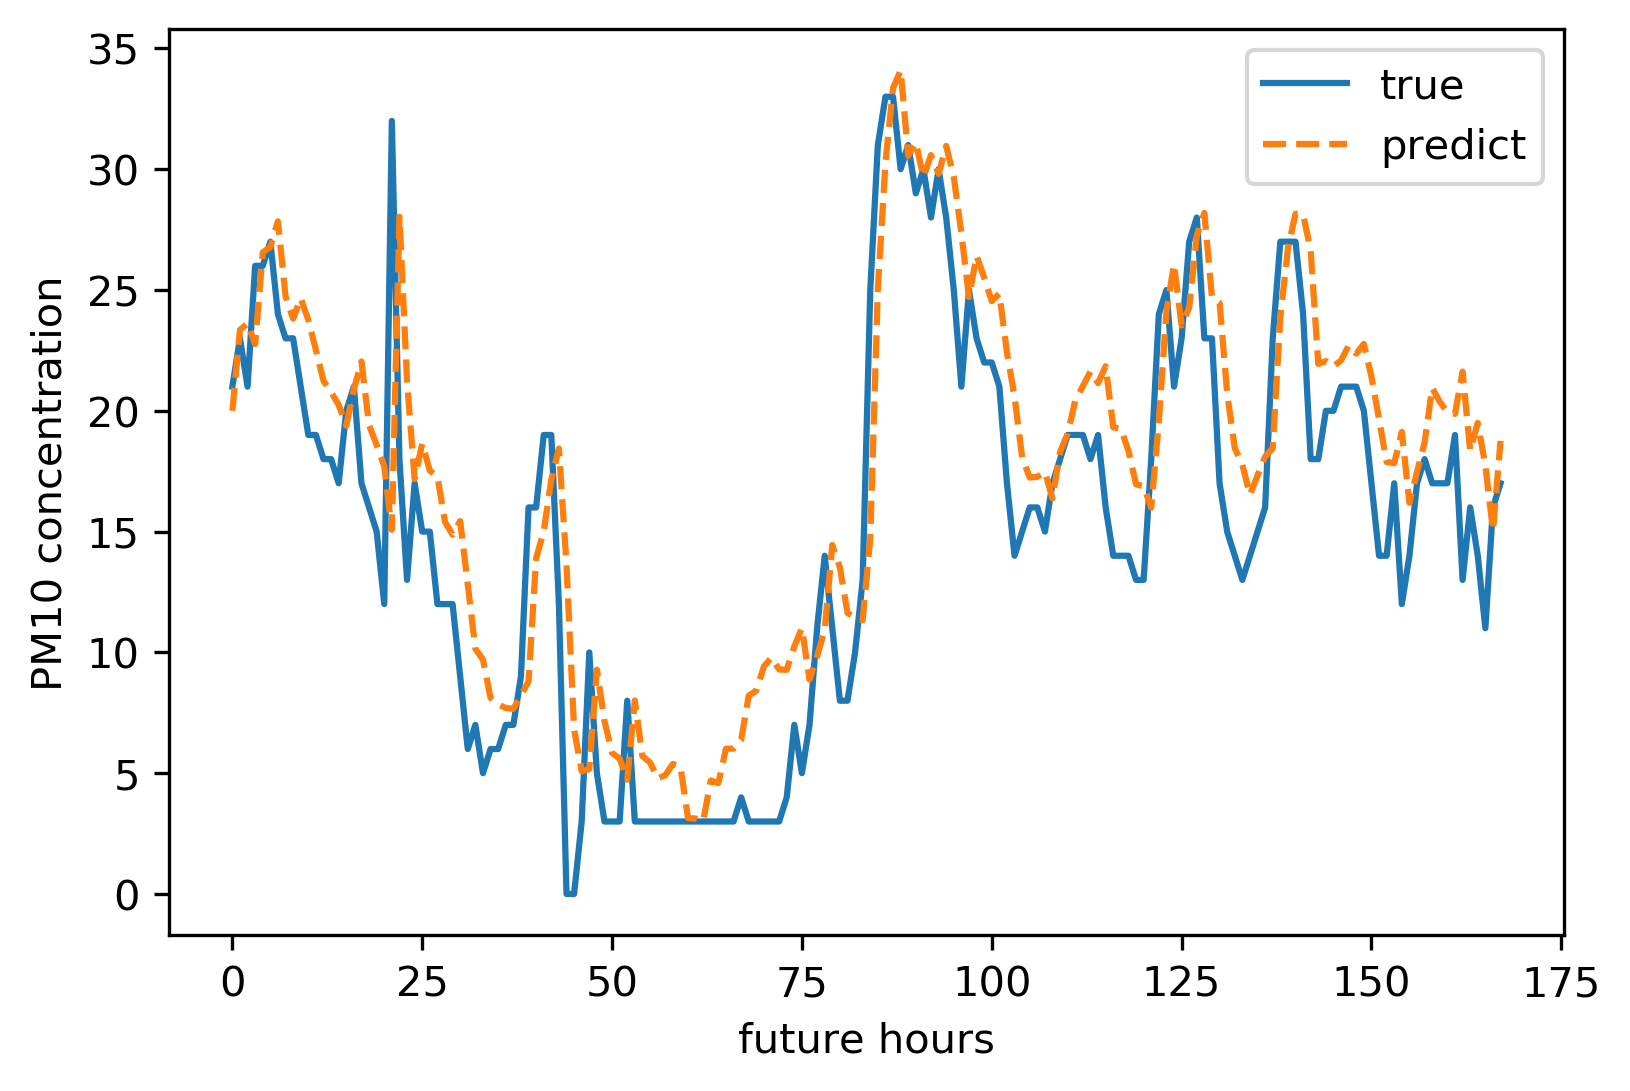

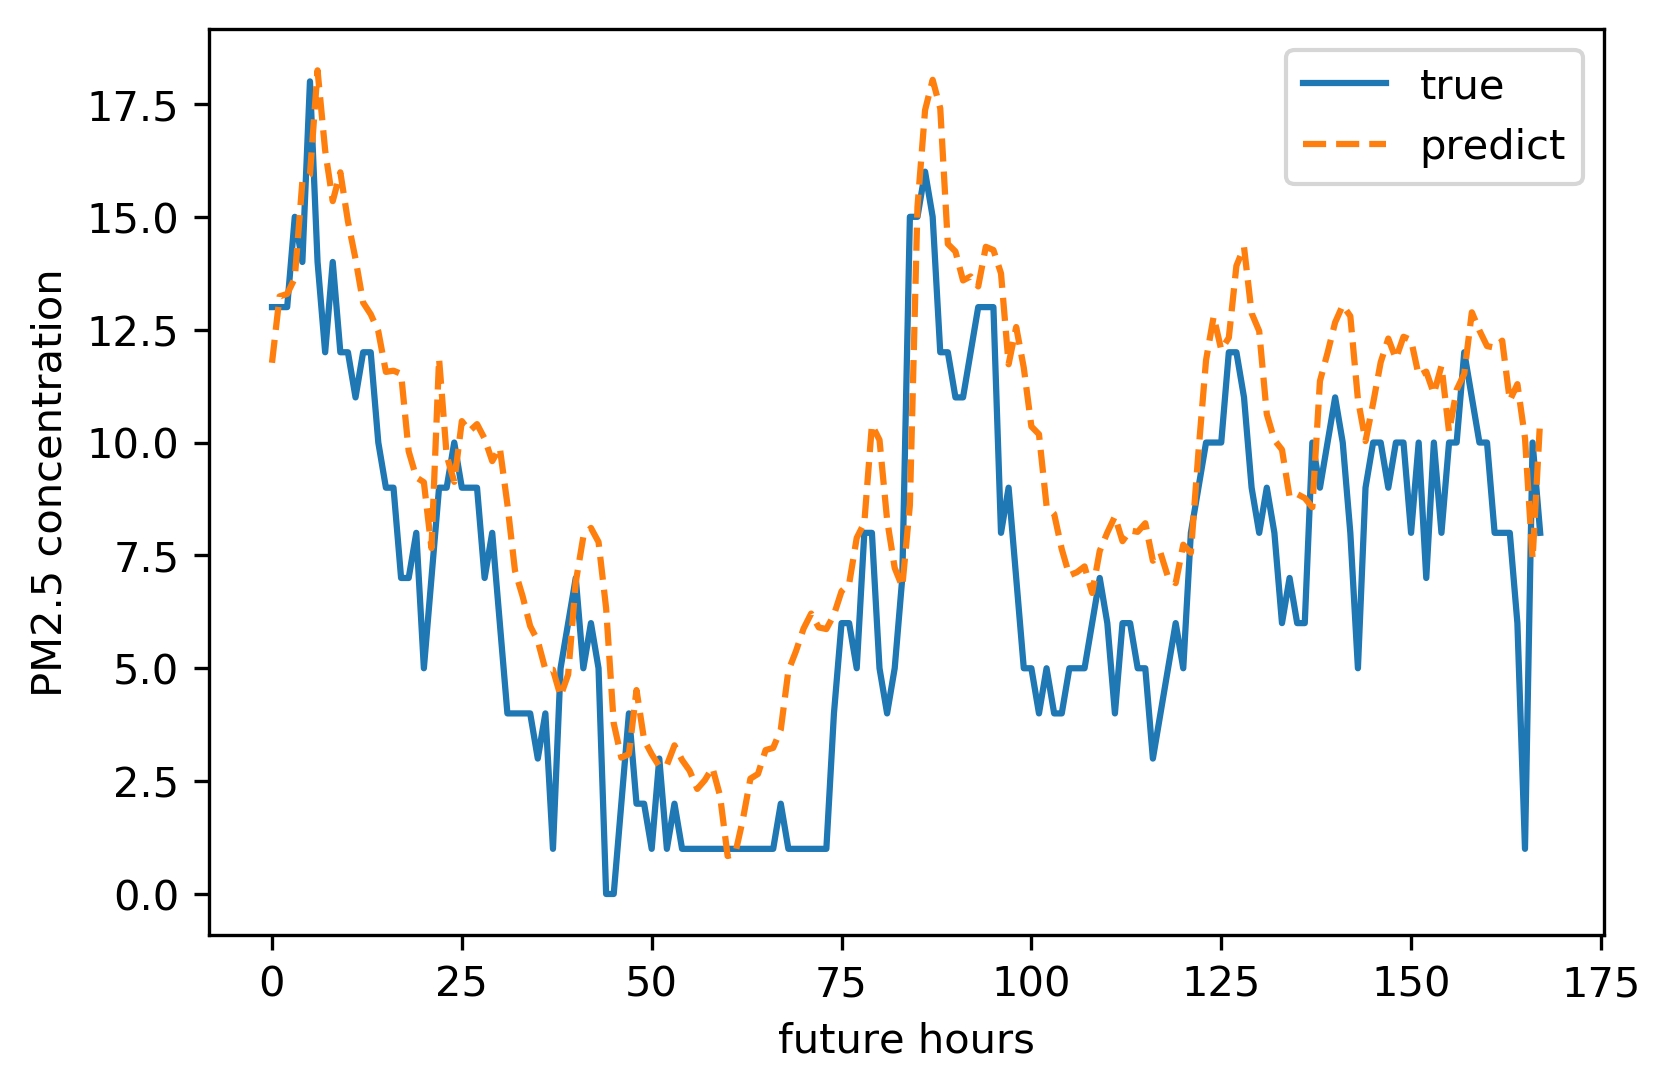

In [25]:
pre_print(gru)

1/1 [==============================] - 0s 176ms/step
loss and acc: [0.00036289068521000445, 0.636904776096344]
(1, 168, 2)
rmse_pm10: 5.041
mae_pm10:  4.308
rmse_pm25: 2.939
mae_pm25:  2.518


c:\users\tim\documents\predicting_models\prepare_for_journal\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\tim\documents\predicting_models\prepare_for_journal\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\tim\documents\predicting_models\prepare_for_journal\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


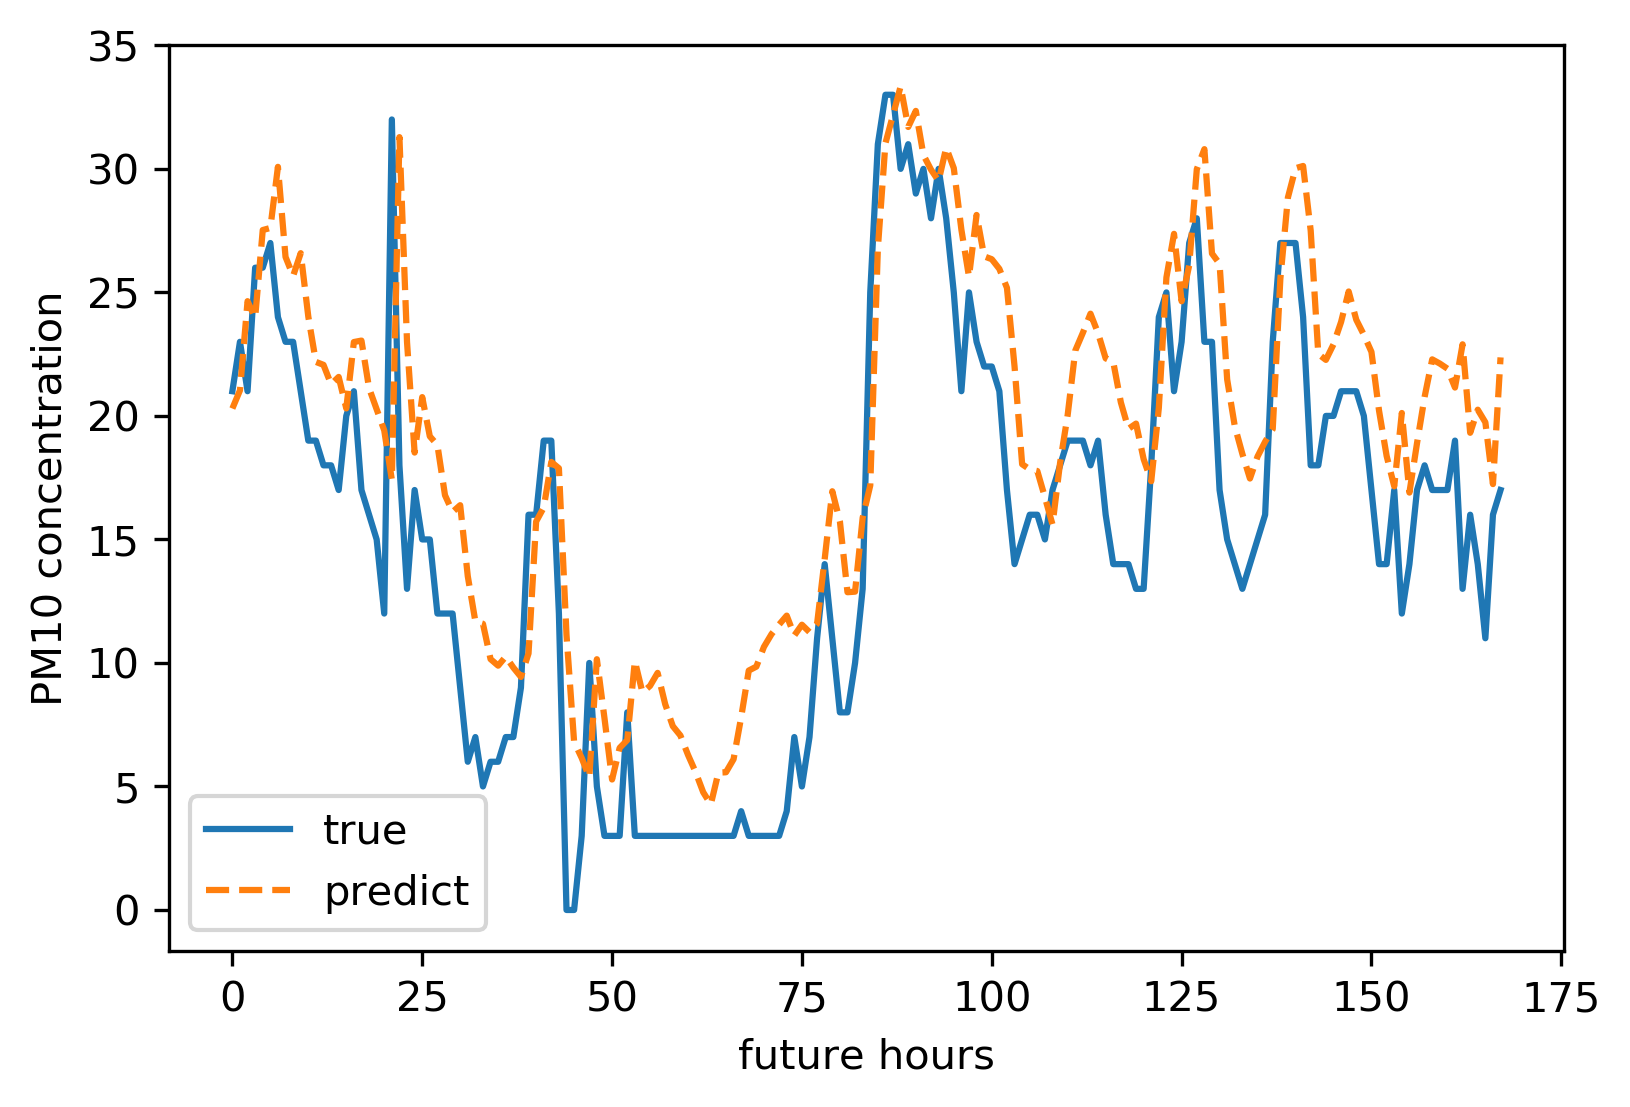

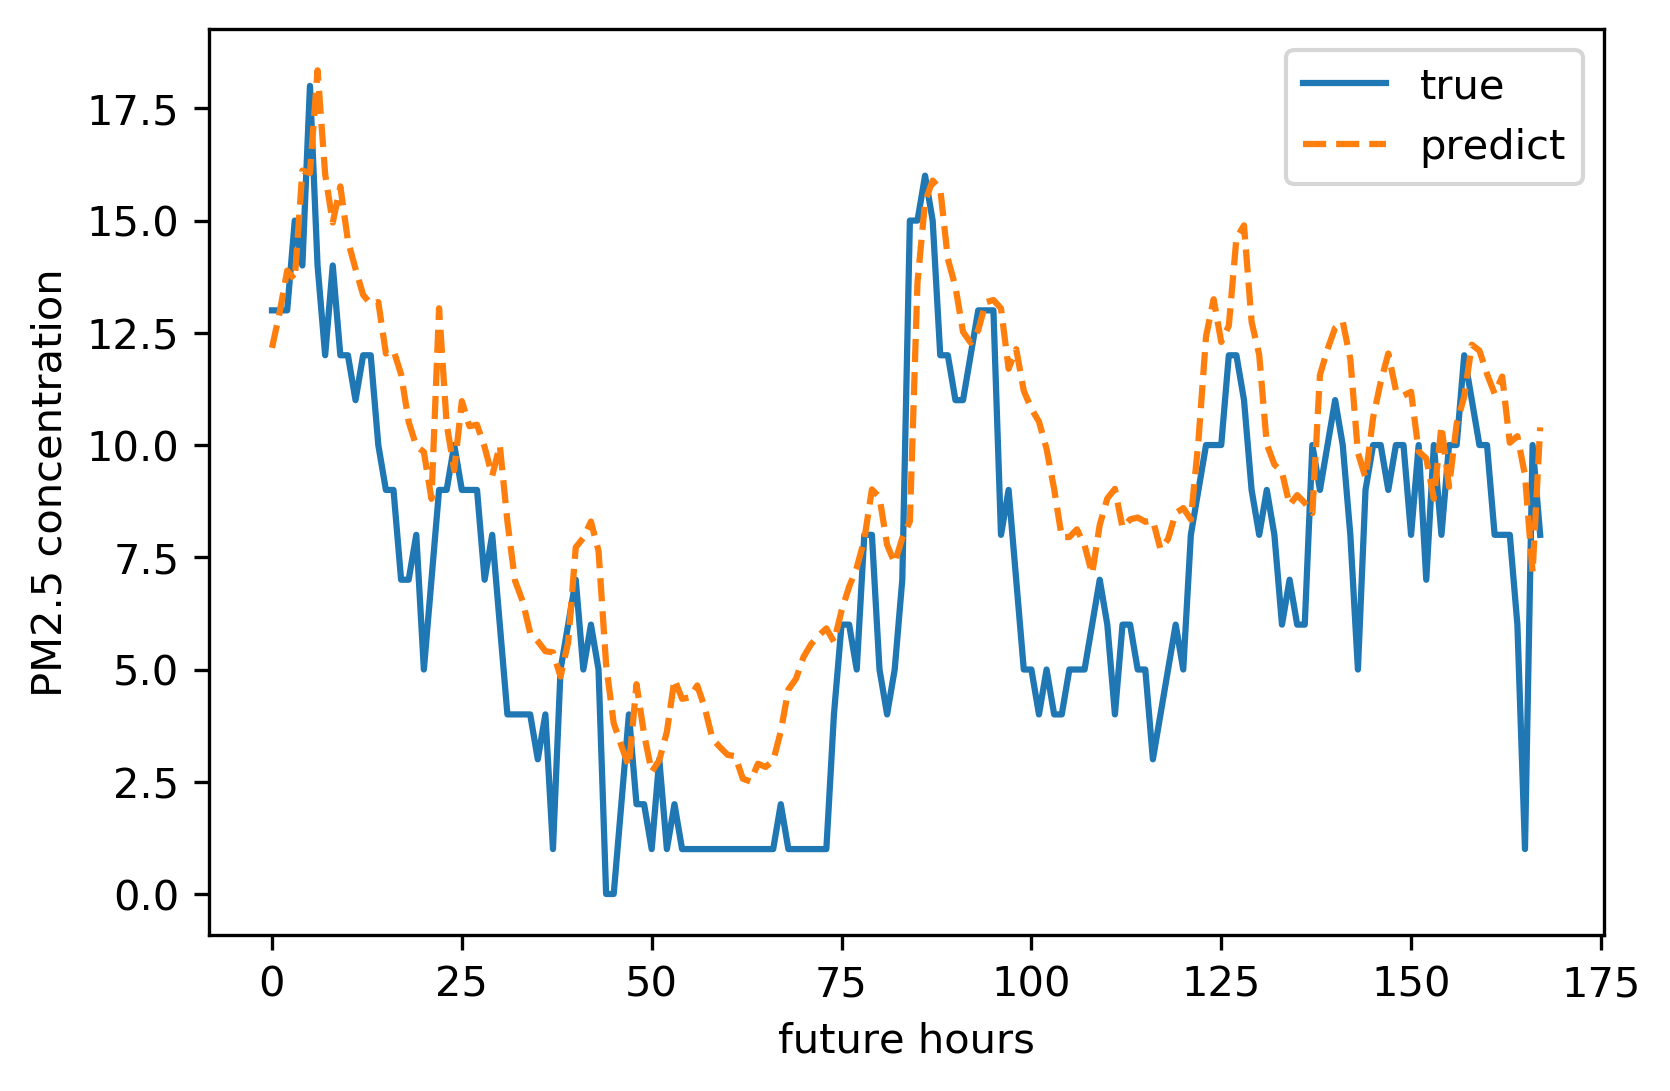

In [26]:
pre_print(lstm)

1/1 [==============================] - 0s 72ms/step
loss and acc: [5.302501085679978e-05, 0.875]
(1, 168, 2)
rmse_pm10: 1.969
mae_pm10:  1.667
rmse_pm25: 1.108
mae_pm25:  0.958


c:\users\tim\documents\predicting_models\prepare_for_journal\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\tim\documents\predicting_models\prepare_for_journal\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\tim\documents\predicting_models\prepare_for_journal\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


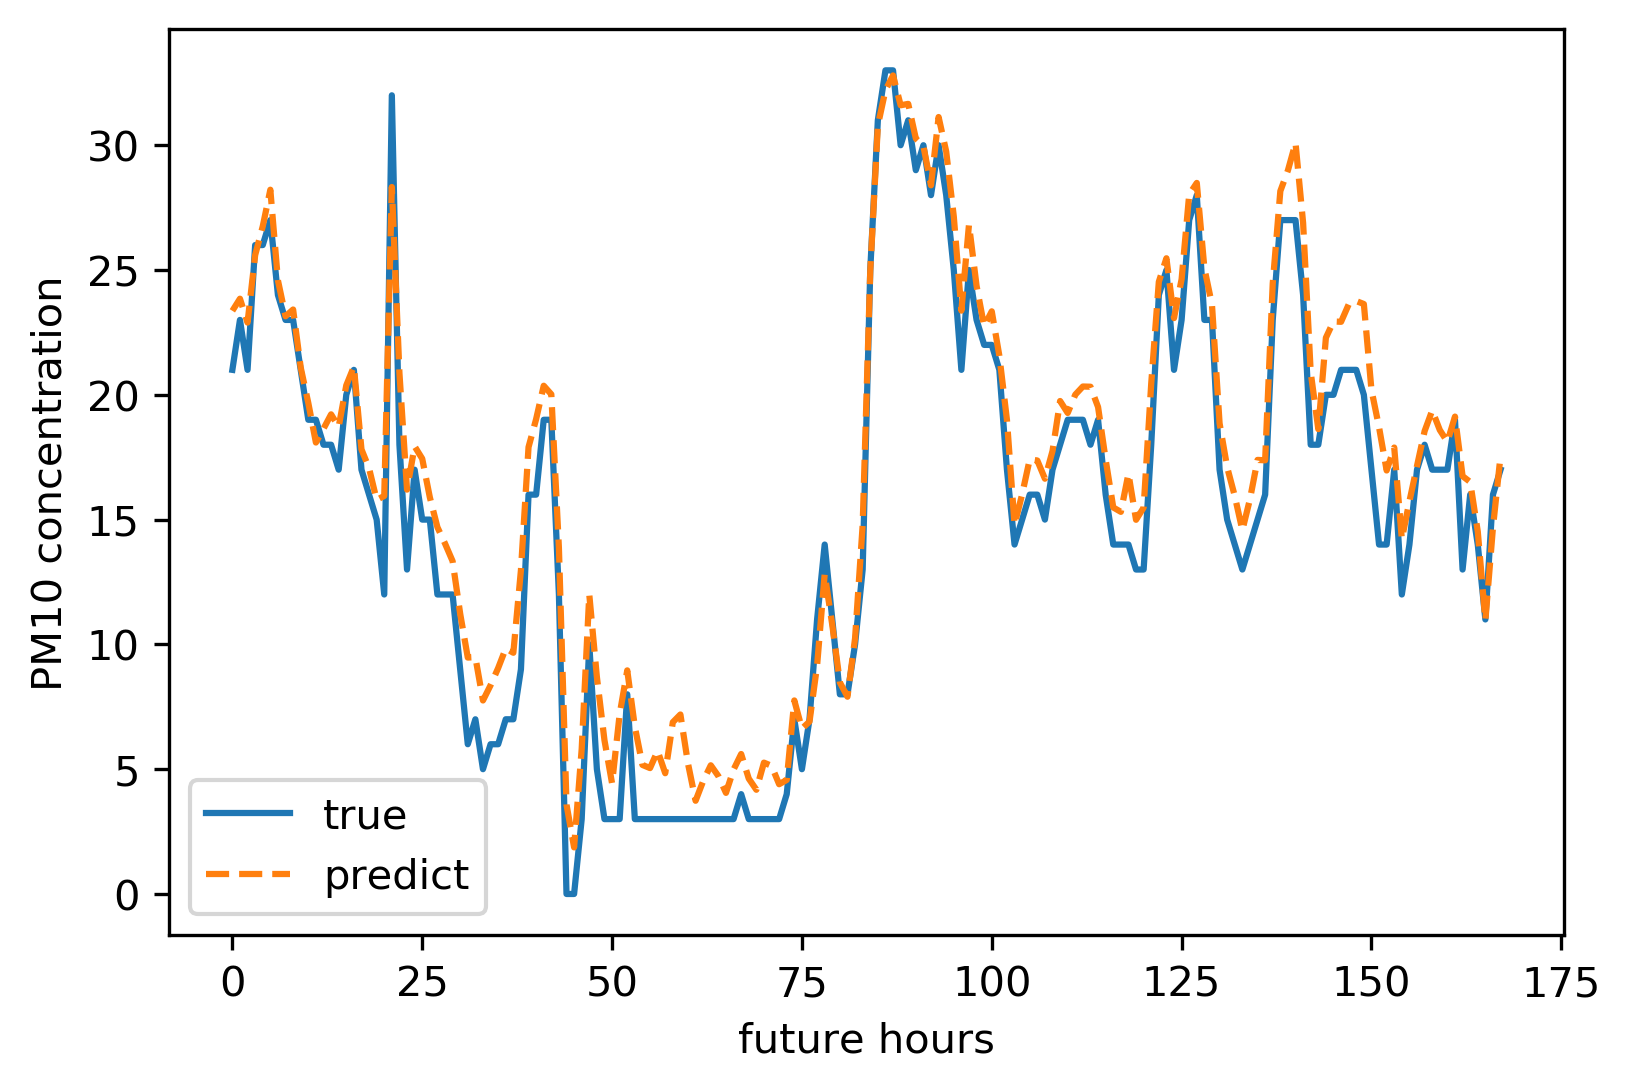

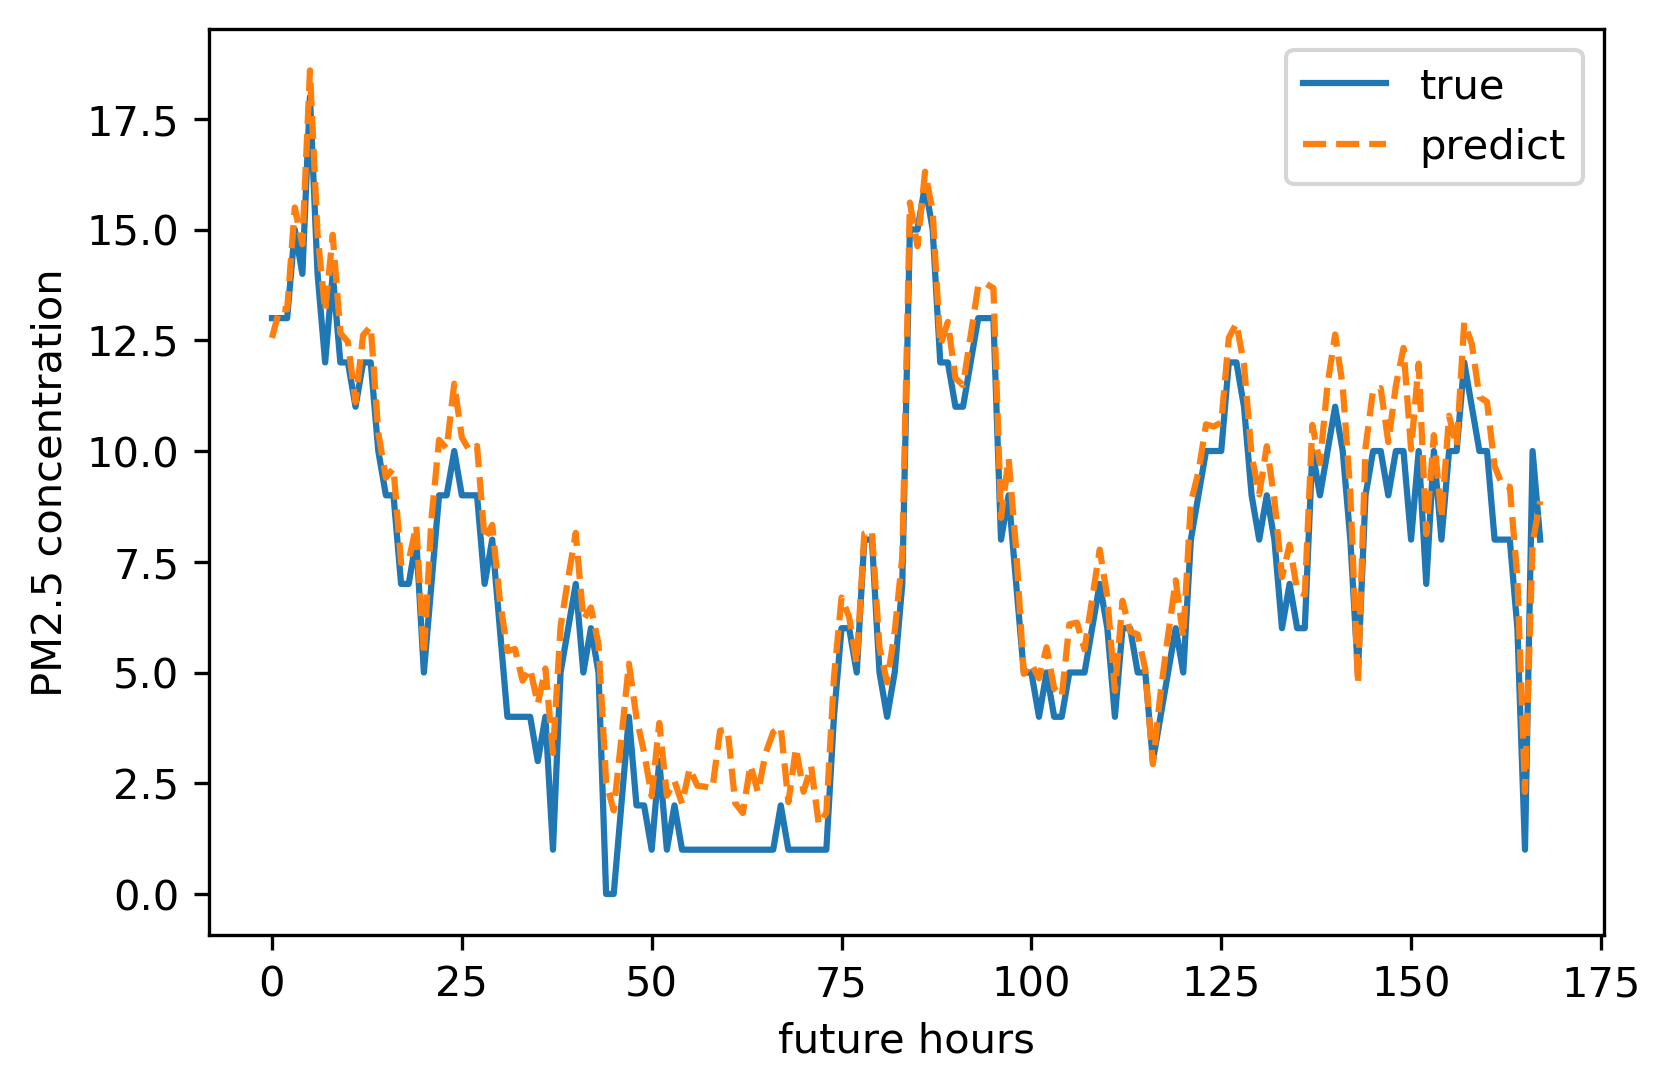

In [27]:
pre_print(hybrid)

1/1 [==============================] - 0s 87ms/step
loss and acc: [4.346841251390288e-06, 0.9345238208770752]
(1, 168, 2)
rmse_pm10: 0.485
mae_pm10:  0.401
rmse_pm25: 0.344
mae_pm25:  0.241


c:\users\tim\documents\predicting_models\prepare_for_journal\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\tim\documents\predicting_models\prepare_for_journal\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\tim\documents\predicting_models\prepare_for_journal\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


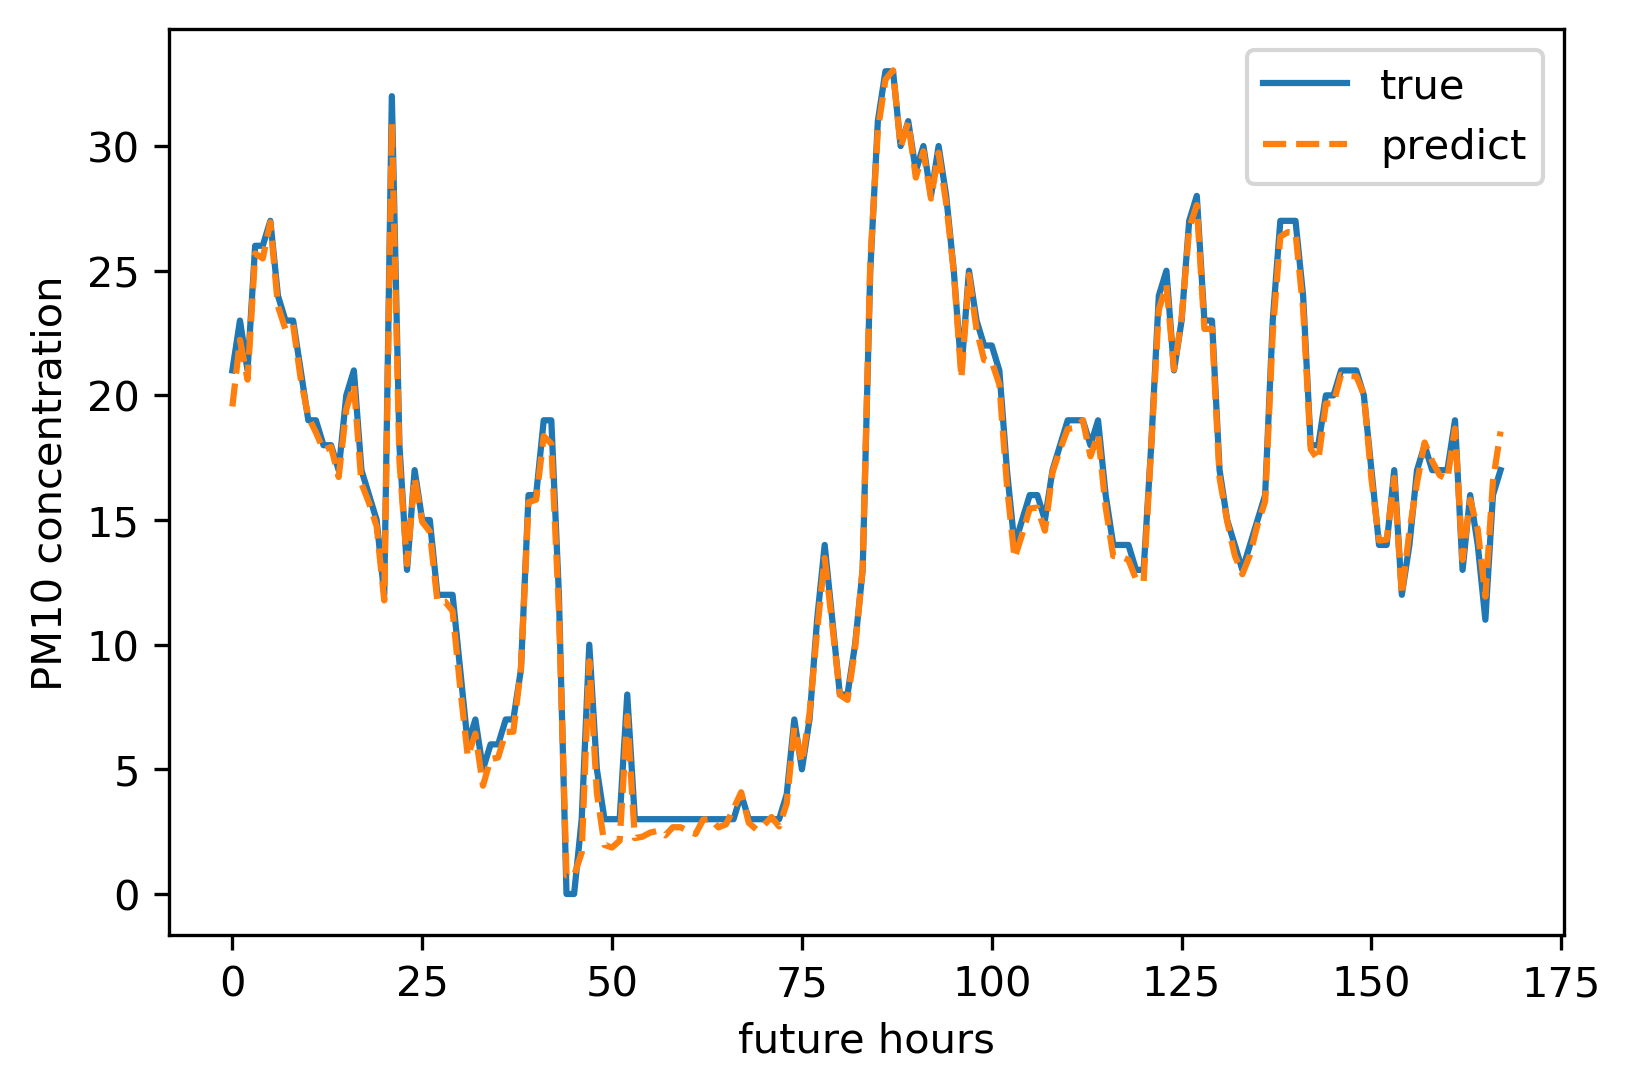

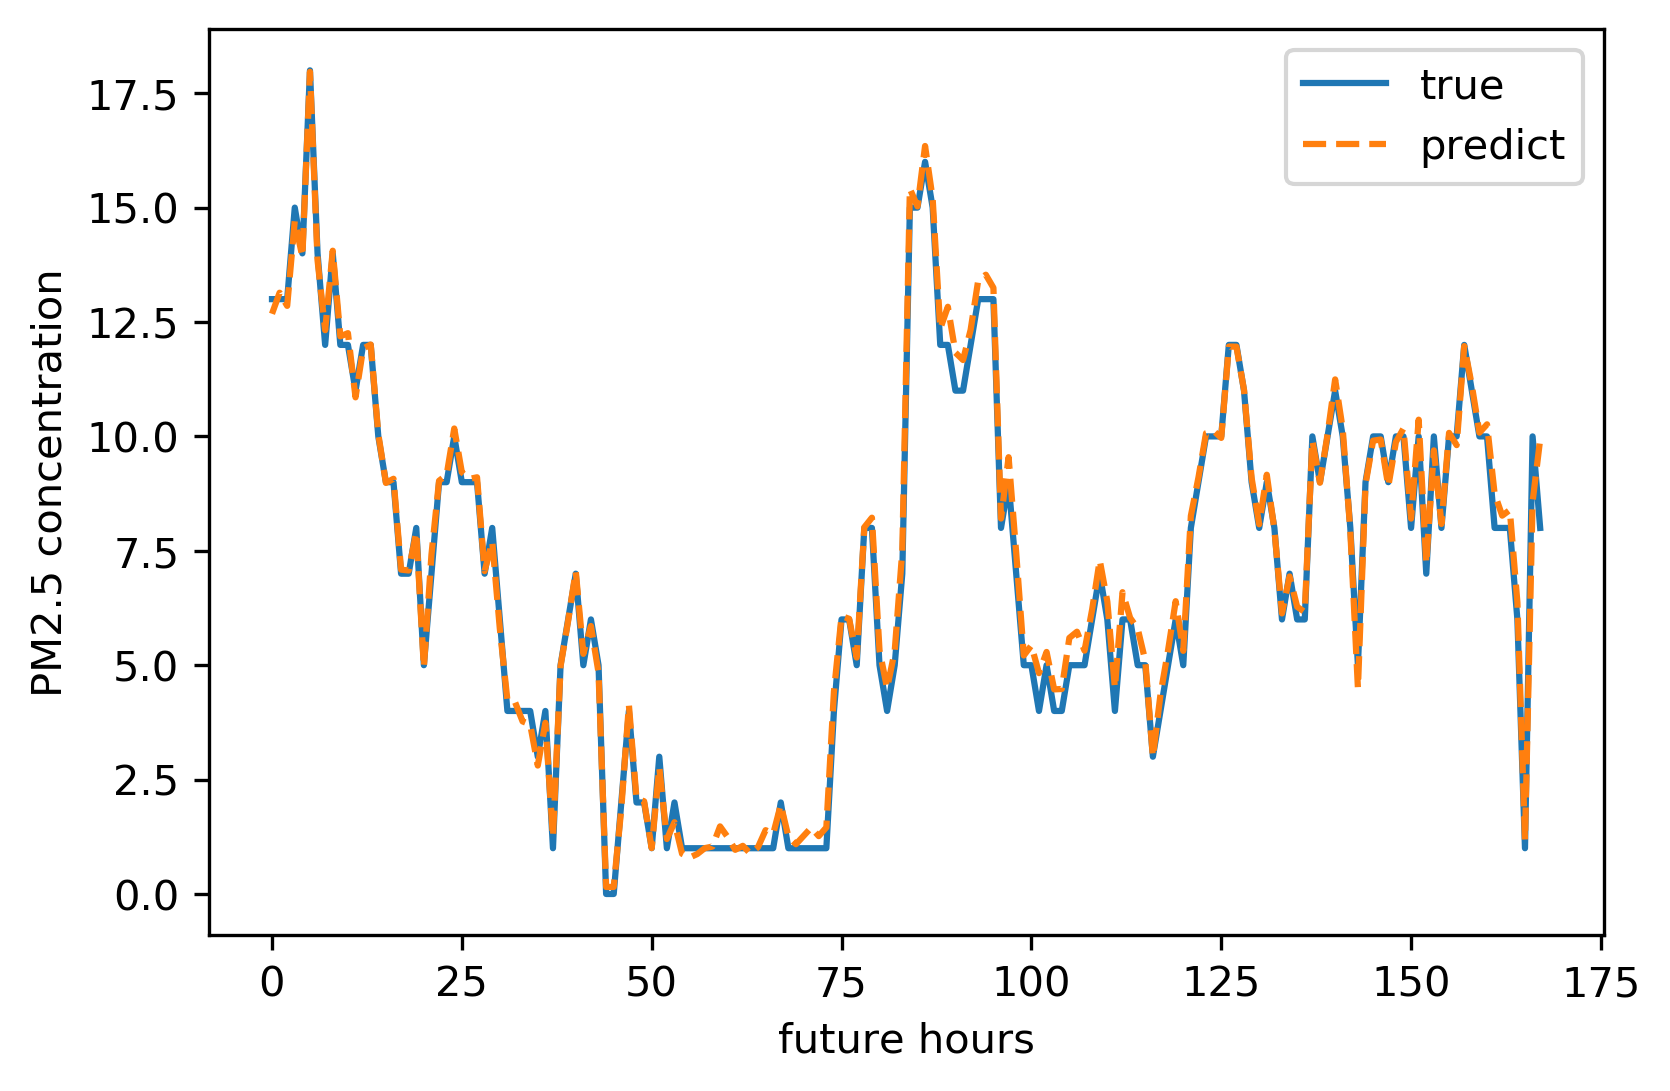

In [28]:
pre_print(hybrid2)

In [29]:
sep_size=y_test.shape[0]//stations
y_test_avg=np.zeros((sep_size,  2))
cnn_hat_avg=np.zeros((sep_size, 2))
gru_hat_avg=np.zeros((sep_size, 2))
lstm_hat_avg=np.zeros((sep_size, 2))
hybrid_hat_avg=np.zeros((sep_size, 2))
hybrid2_hat_avg=np.zeros((sep_size, 2))

for i in range(sep_size):
    y_test_avg[i, 0]=np.mean(y_test[i*stations:stations*(i+1),0])
    y_test_avg[i, 1]=np.mean(y_test[i*stations:stations*(i+1),1])
        
    cnn_hat_avg[i, 0]=np.mean(cnn_hat[i*stations:stations*(i+1),0])
    cnn_hat_avg[i, 1]=np.mean(cnn_hat[i*stations:stations*(i+1),1])
    
    gru_hat_avg[i, 0]=np.mean(gru_hat[i*stations:stations*(i+1),0])
    gru_hat_avg[i, 1]=np.mean(gru_hat[i*stations:stations*(i+1),1])
    
    lstm_hat_avg[i, 0]=np.mean(lstm_hat[i*stations:stations*(i+1),0])
    lstm_hat_avg[i, 1]=np.mean(lstm_hat[i*stations:stations*(i+1),1])
    
    hybrid_hat_avg[i, 0]=np.mean(hybrid_hat[i*stations:stations*(i+1),0])
    hybrid_hat_avg[i, 1]=np.mean(hybrid_hat[i*stations:stations*(i+1),1])
    
    hybrid2_hat_avg[i, 0]=np.mean(hybrid2_hat[i*stations:stations*(i+1),0])
    hybrid2_hat_avg[i, 1]=np.mean(hybrid2_hat[i*stations:stations*(i+1),1])

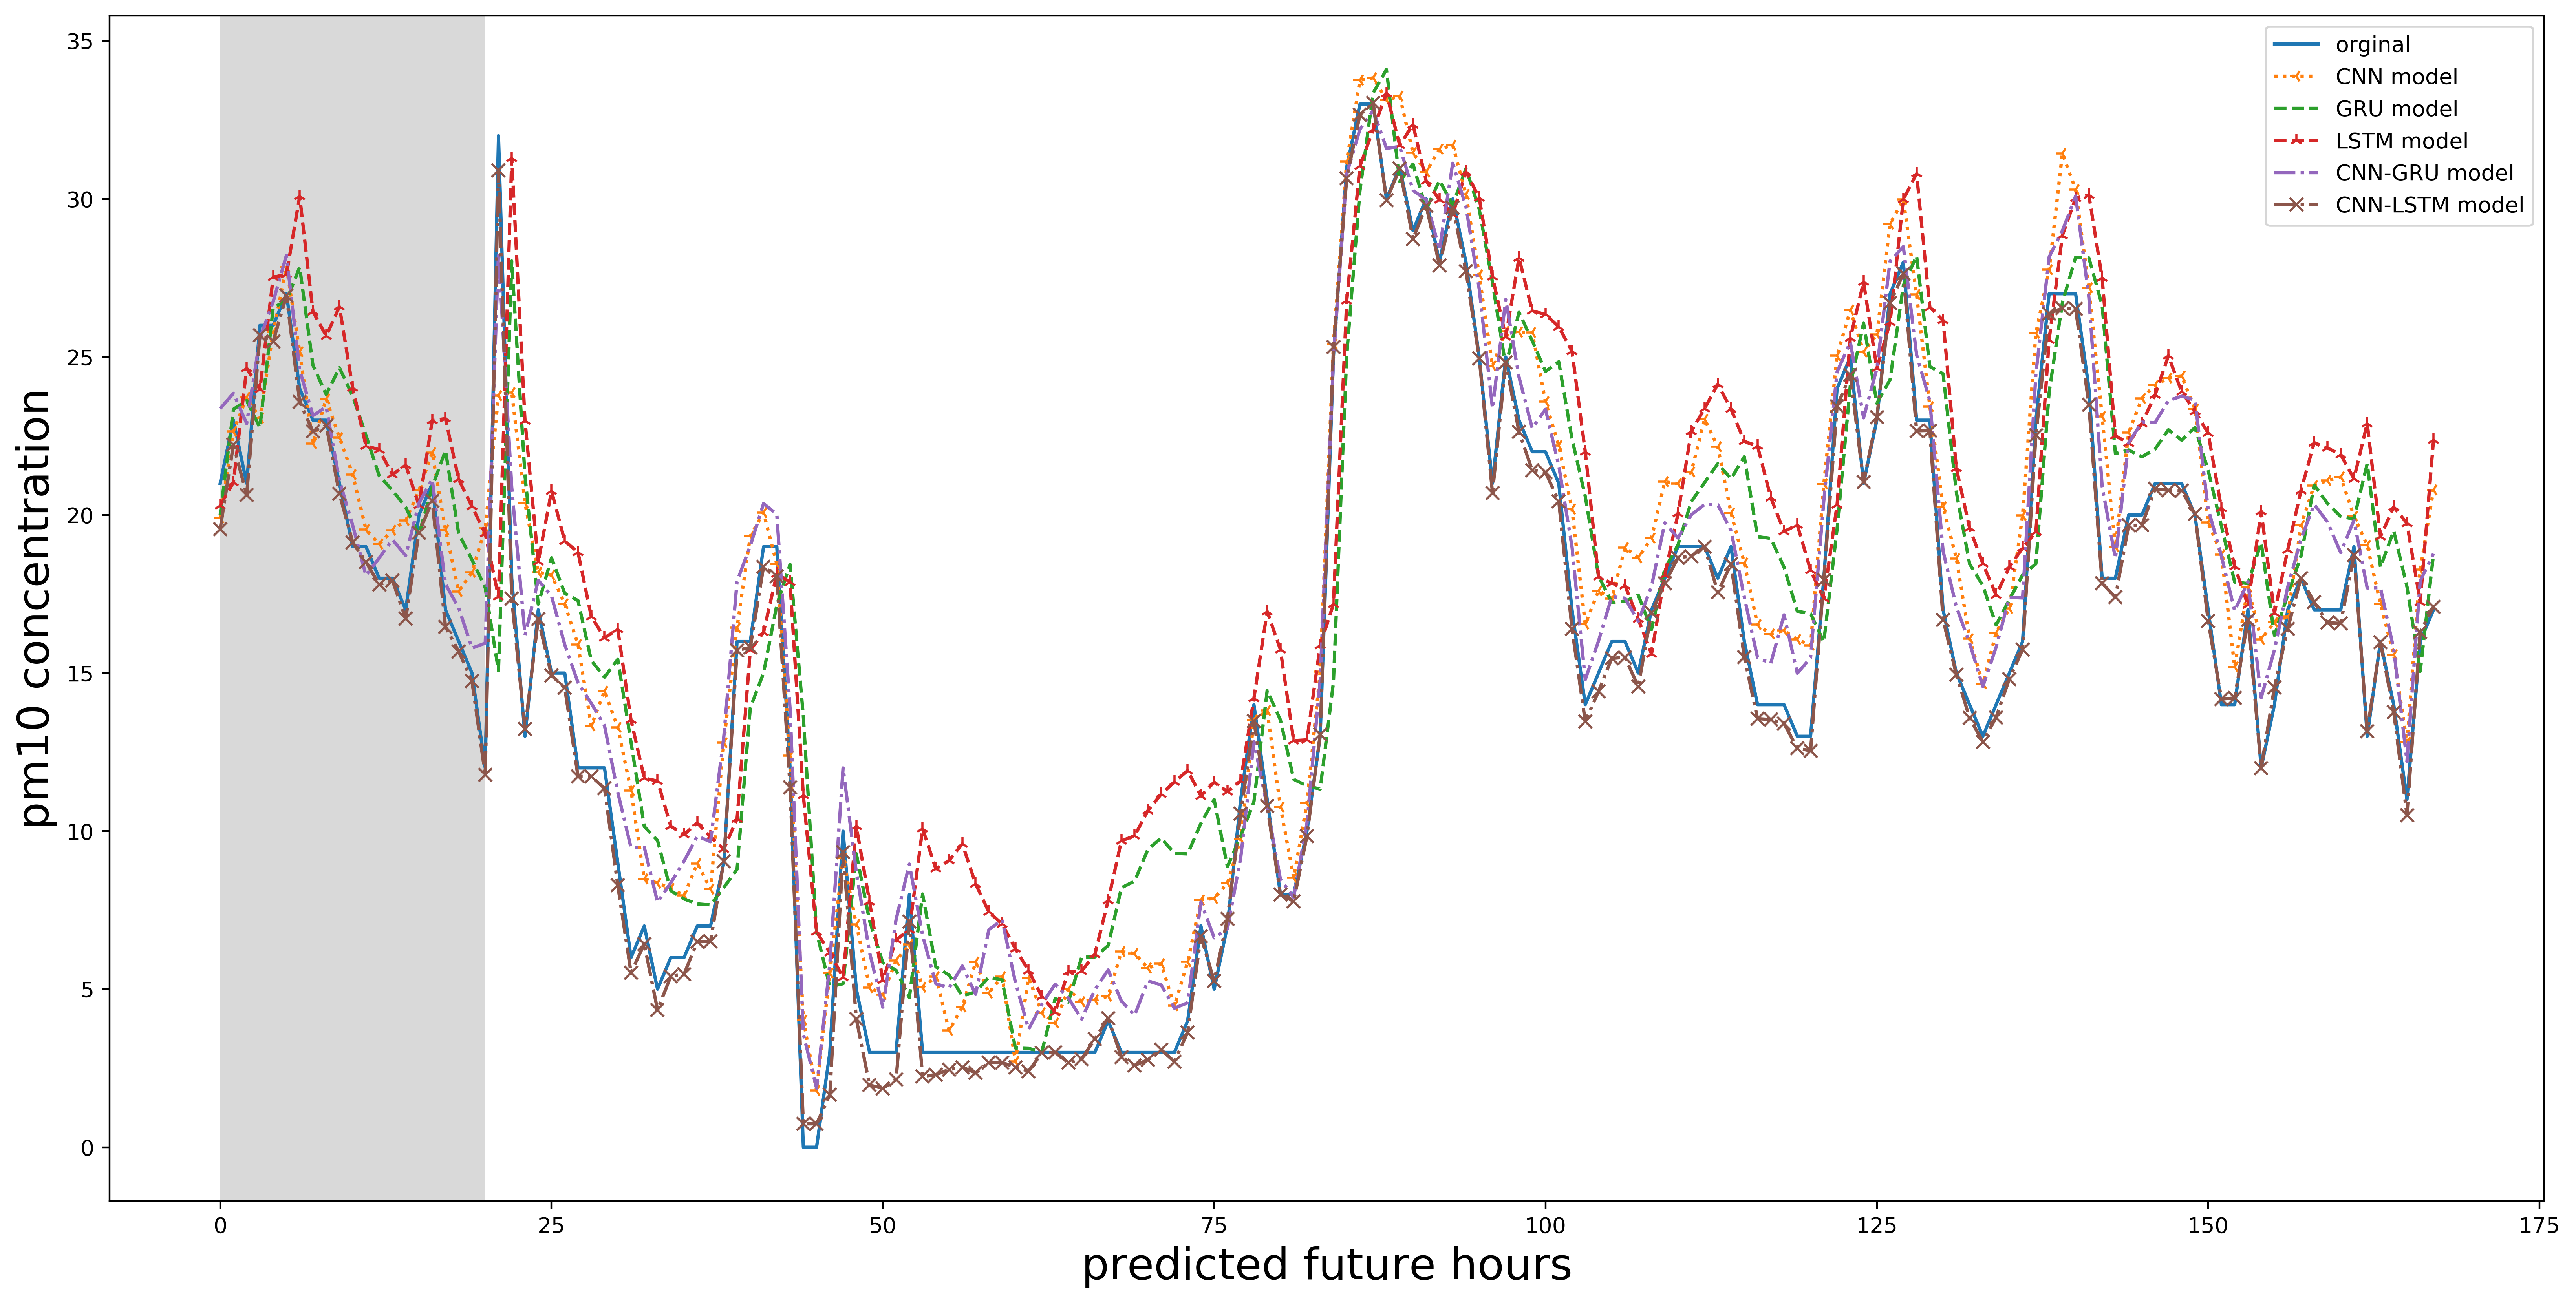

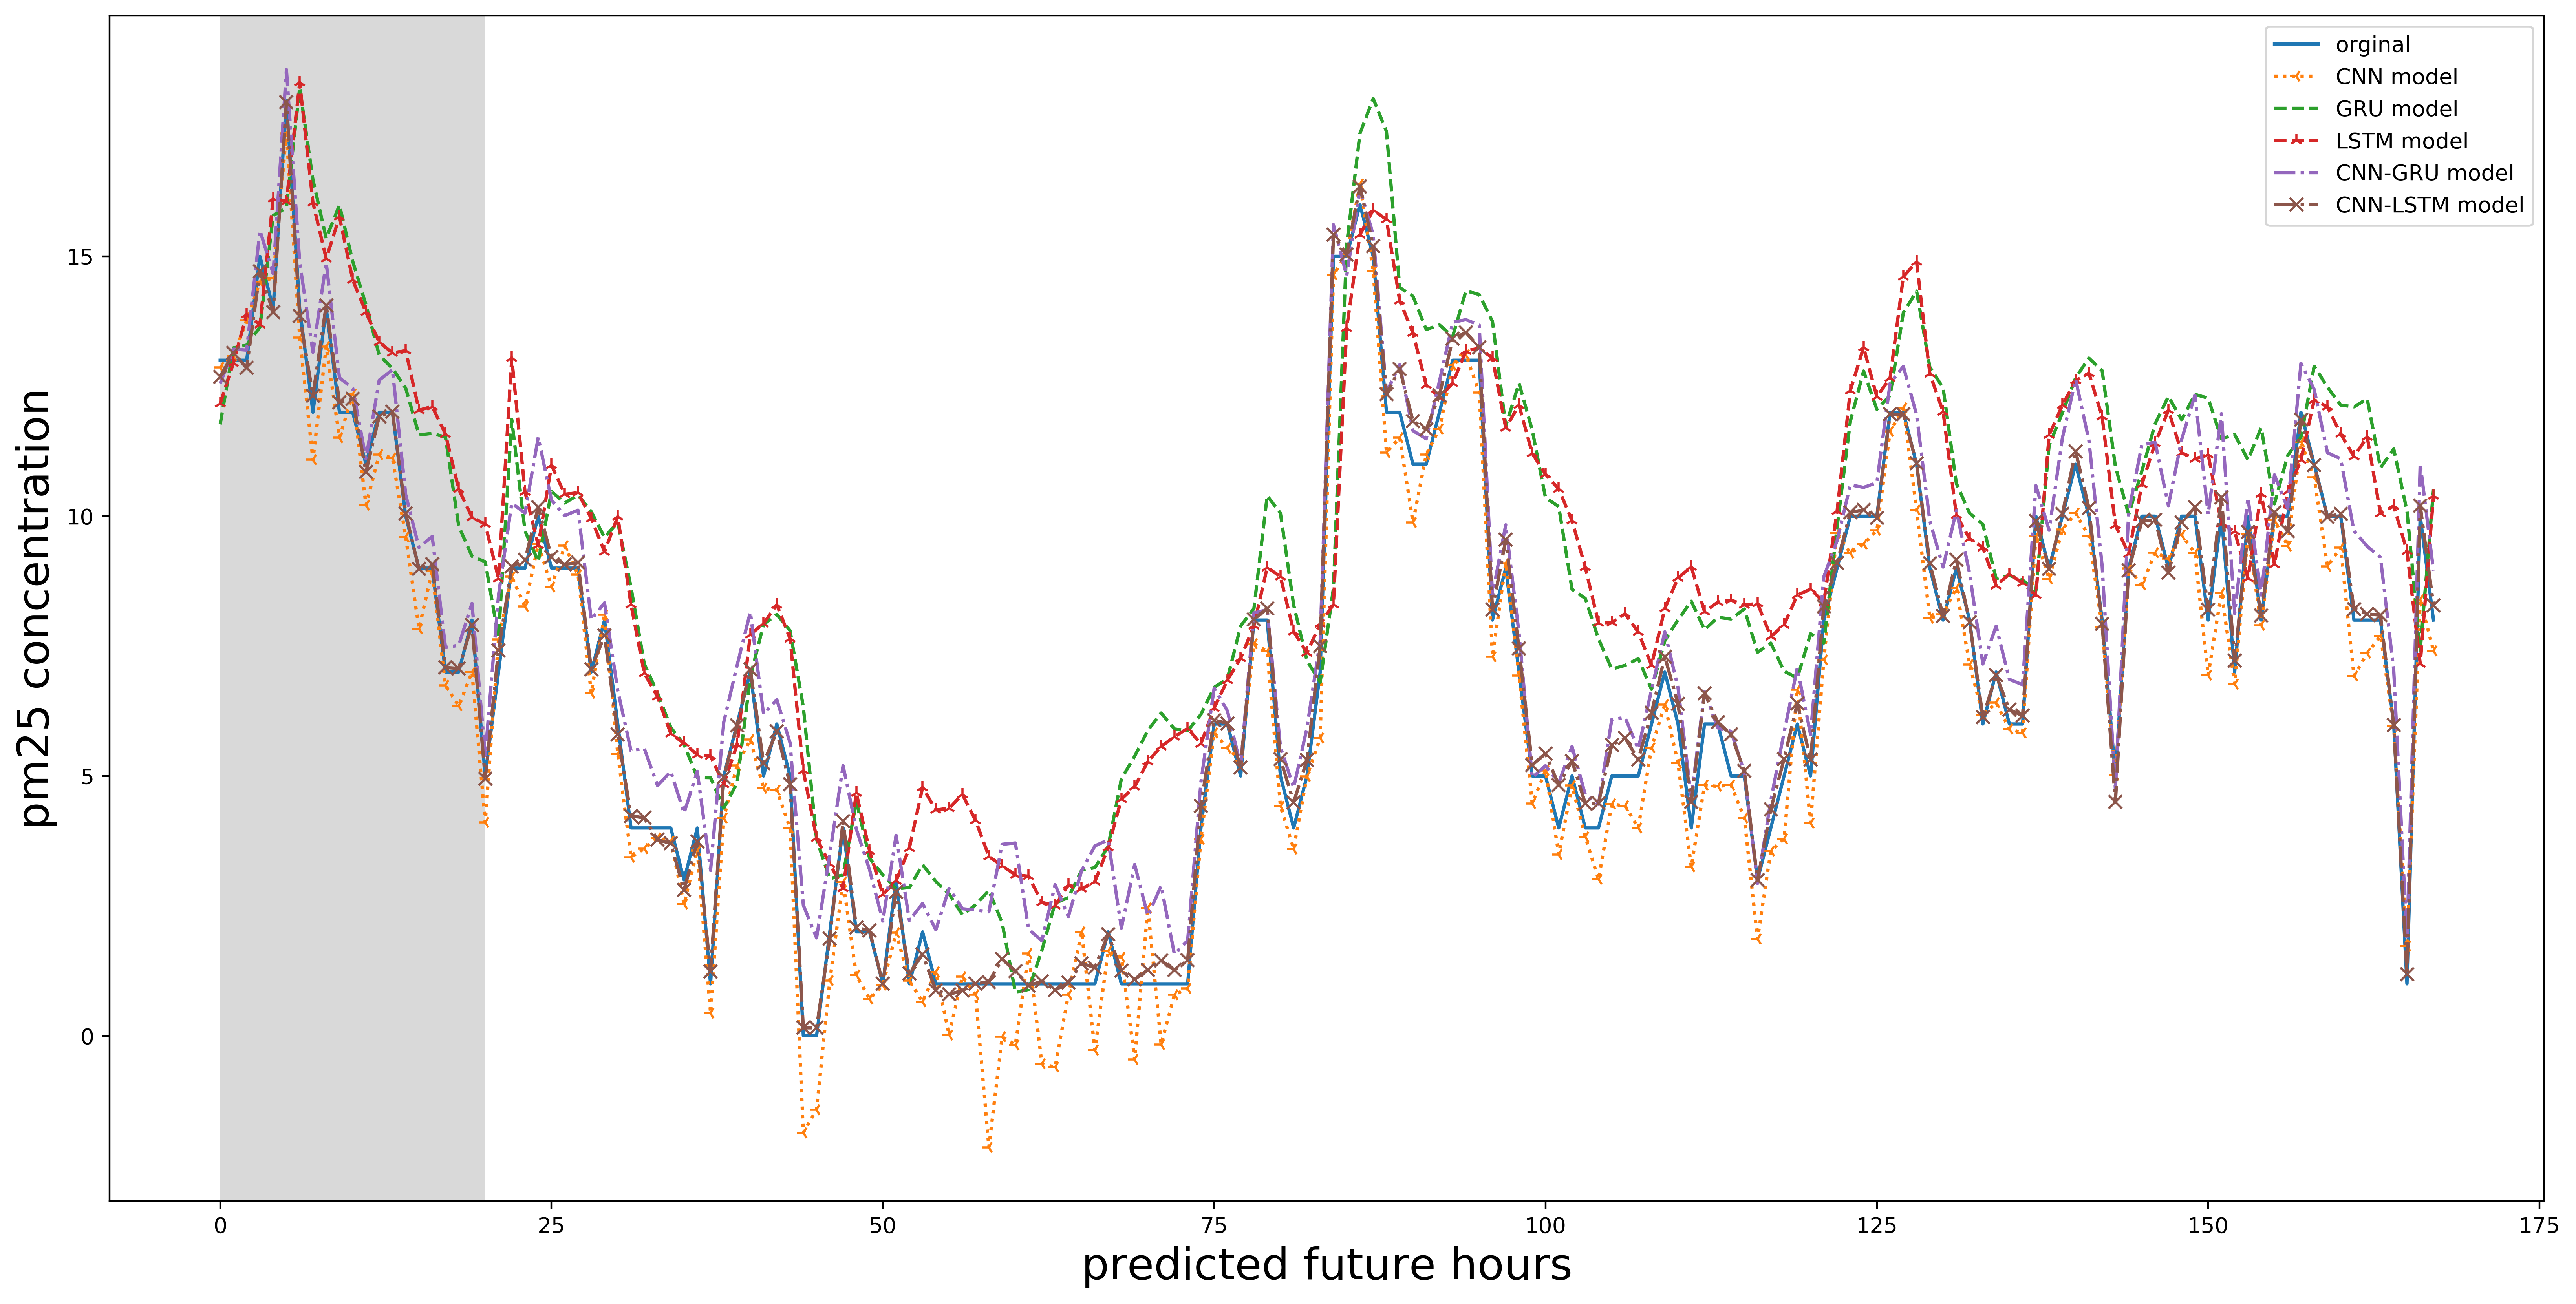

In [30]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10),dpi=400)
plt.plot(y_test_avg[:24*7, 0], label='orginal')

plt.plot(cnn_hat_avg[:24*7, 0], label='CNN model', linestyle=':',marker='3')
plt.plot(gru_hat_avg[:24*7, 0], label='GRU model', linestyle='--')
plt.plot(lstm_hat_avg[:24*7, 0], label='LSTM model', linestyle='--', marker='2')
plt.plot(hybrid_hat_avg[:24*7, 0], label='CNN-GRU model', linestyle='-.')
plt.plot(hybrid2_hat_avg[:24*7, 0], label='CNN-LSTM model', linestyle='-.', marker='x')
plt.ylabel('pm10 concentration', fontsize=20)
#plt.xlabel('data steps (GRU model)')
plt.xlabel('predicted future hours',fontsize=20)
p = plt.axvspan(0, 20, facecolor='black', alpha=0.15)
plt.legend()
plt.show()

#each time steps represents for predicting one hour long
plt.figure(figsize=(20,10), dpi=400)
plt.plot(y_test_avg[:24*7, 1], label='orginal')

plt.plot(cnn_hat_avg[:24*7, 1], label='CNN model', linestyle=':', marker='3')
plt.plot(gru_hat_avg[:24*7, 1], label='GRU model', linestyle='--')
plt.plot(lstm_hat_avg[:24*7, 1], label='LSTM model', linestyle='--', marker='2')
plt.plot(hybrid_hat_avg[:24*7, 1], label='CNN-GRU model', linestyle='-.')
plt.plot(hybrid2_hat_avg[:24*7, 1], label='CNN-LSTM model', linestyle='-.', marker='x')
plt.ylabel('pm25 concentration', fontsize=20)
#plt.xlabel('data steps (GRU model)')
plt.xlabel('predicted future hours', fontsize=20)
p = plt.axvspan(0, 20, facecolor='black', alpha=0.15)
plt.legend()
plt.show()

plt.close('all')

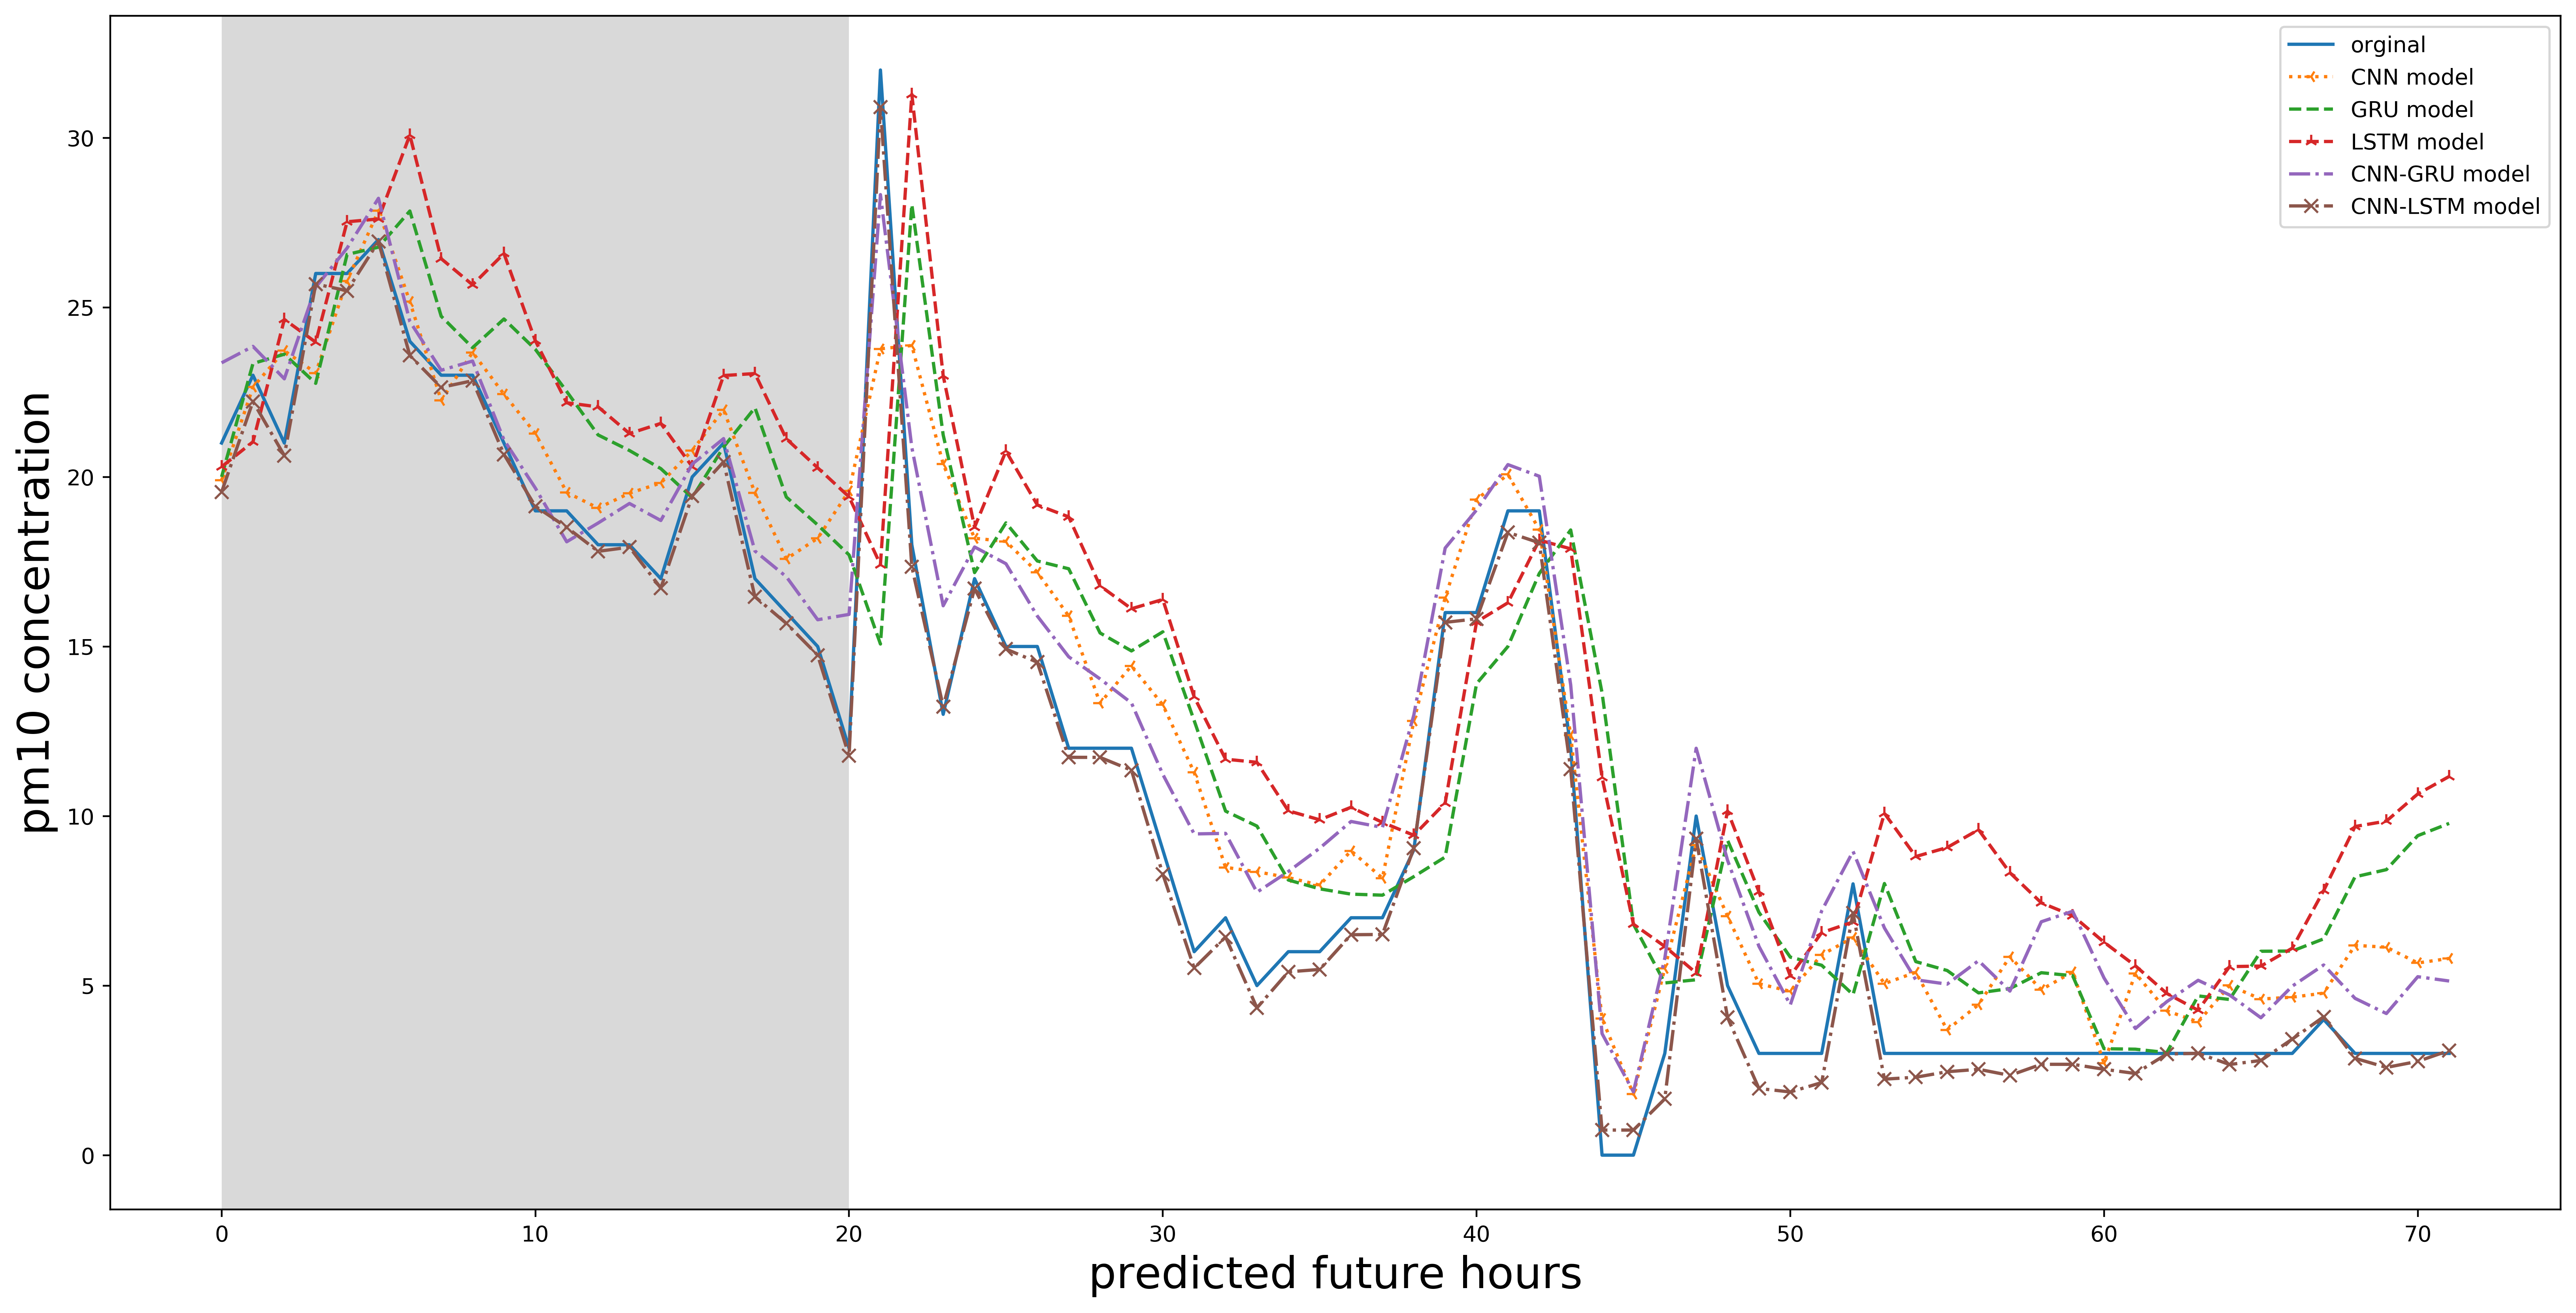

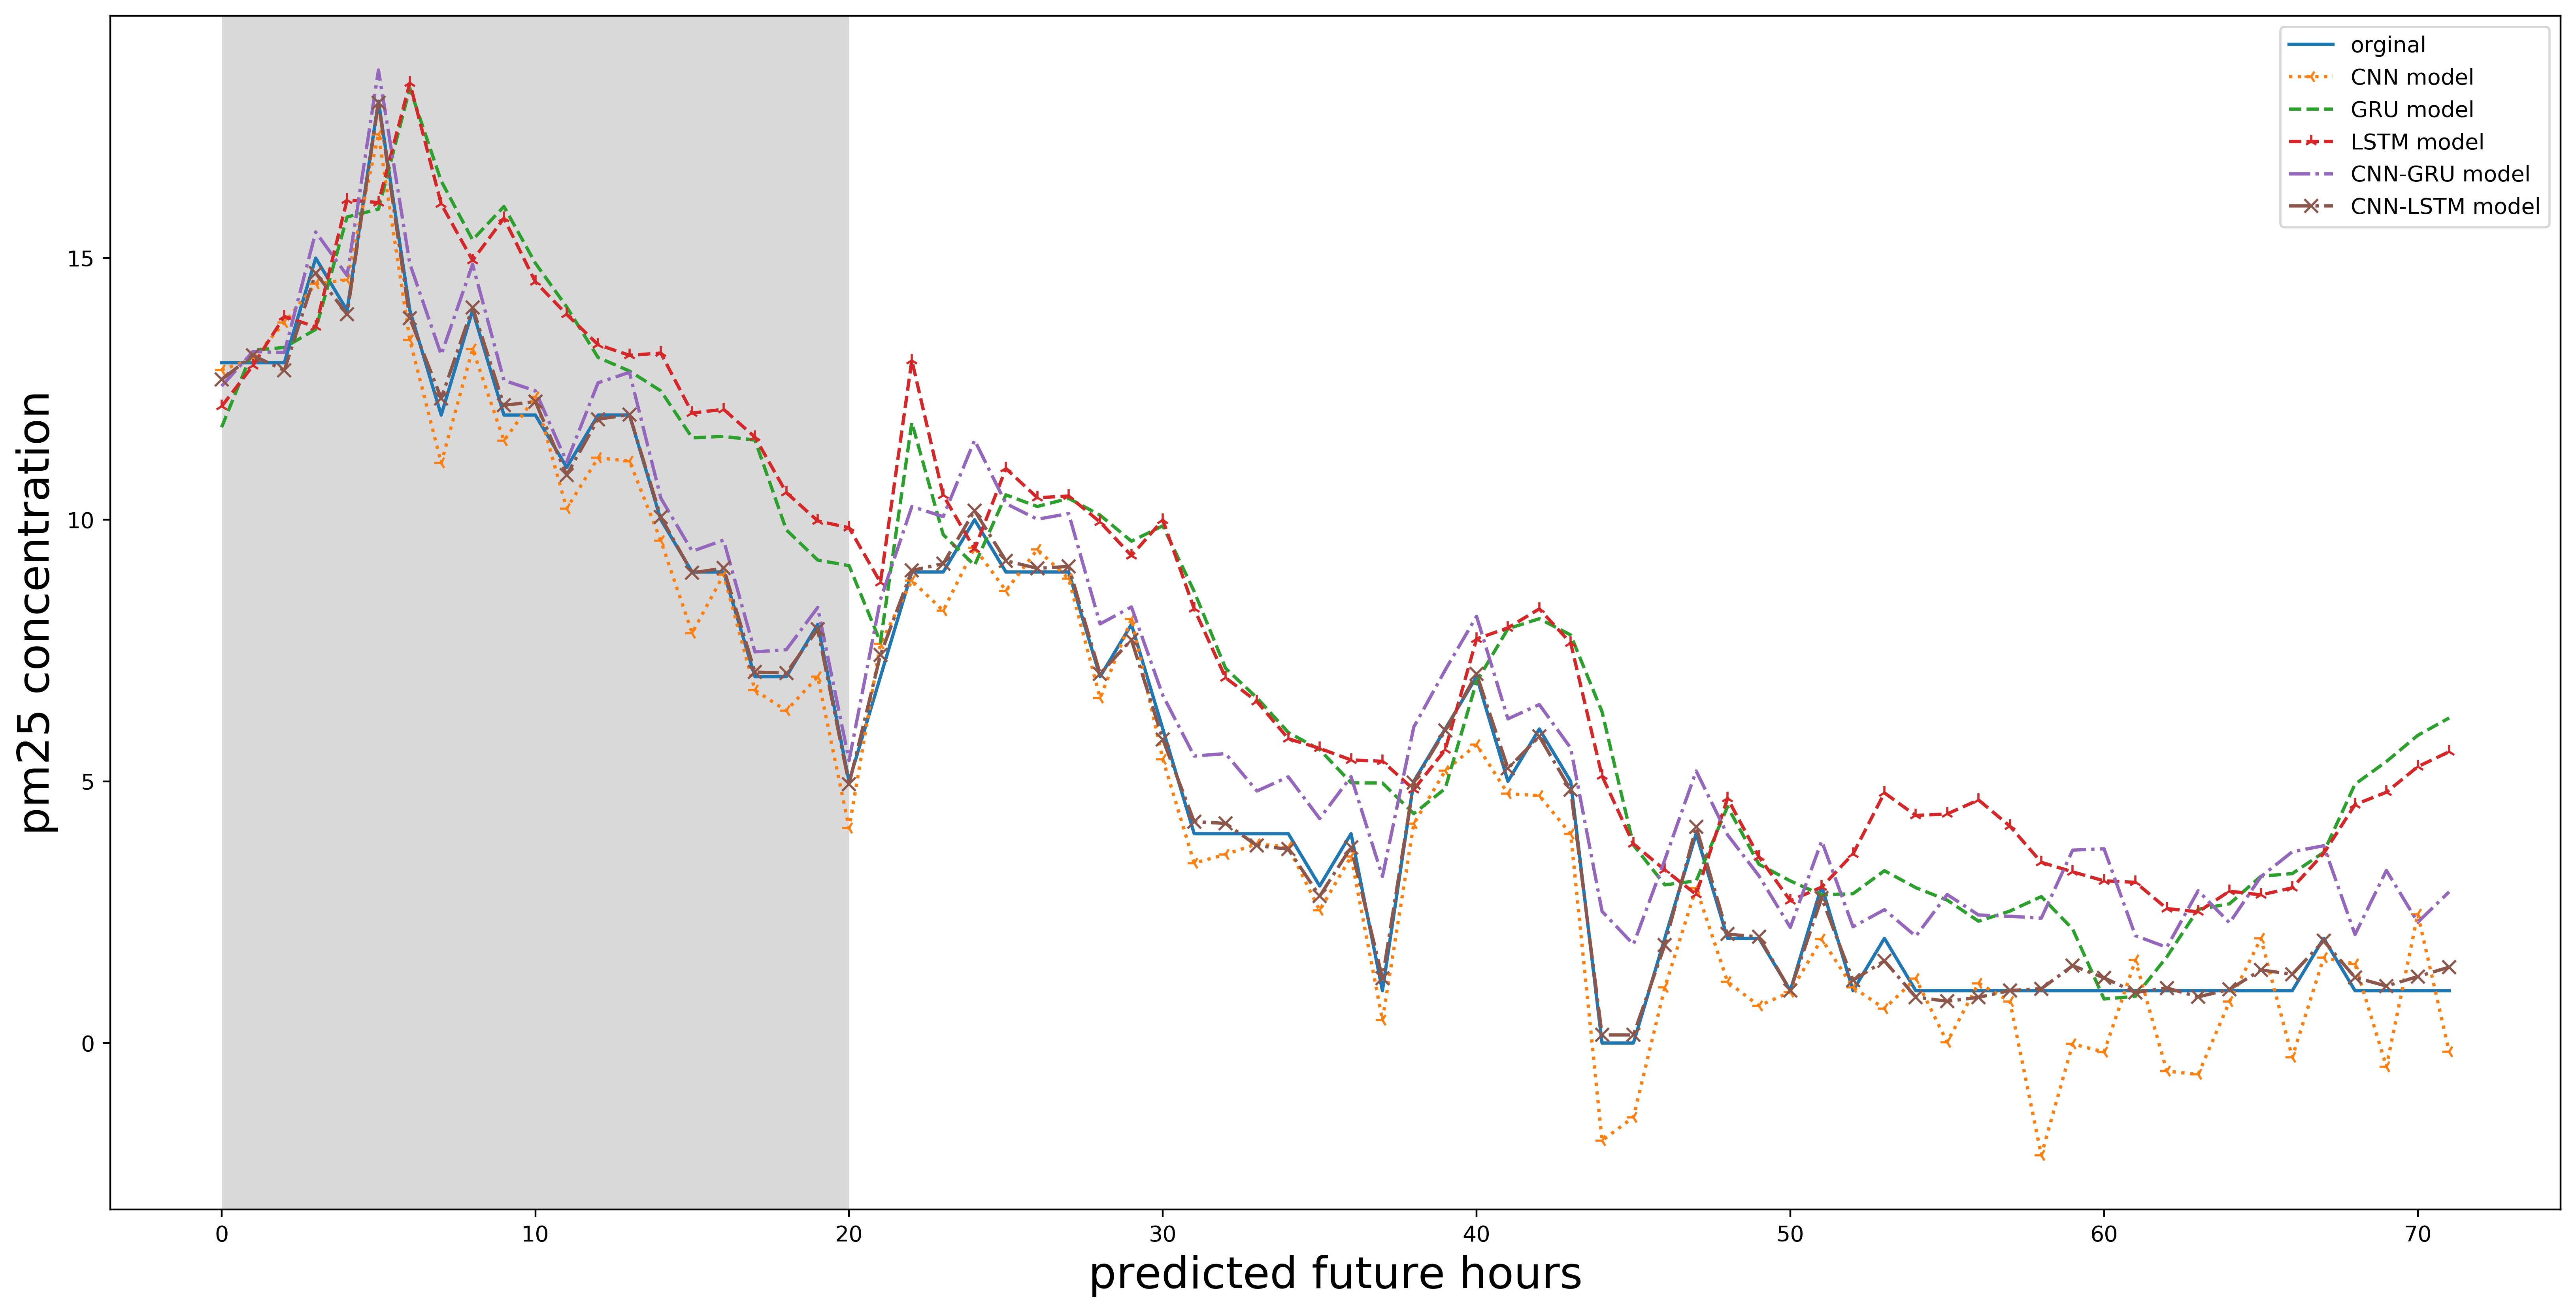

In [31]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10),dpi=400)
plt.plot(y_test_avg[:24*3, 0], label='orginal')

plt.plot(cnn_hat_avg[:24*3, 0], label='CNN model', linestyle=':',marker='3')
plt.plot(gru_hat_avg[:24*3, 0], label='GRU model', linestyle='--')
plt.plot(lstm_hat_avg[:24*3, 0], label='LSTM model', linestyle='--', marker='2')
plt.plot(hybrid_hat_avg[:24*3, 0], label='CNN-GRU model', linestyle='-.')
plt.plot(hybrid2_hat_avg[:24*3, 0], label='CNN-LSTM model', linestyle='-.', marker='x')
plt.ylabel('pm10 concentration', fontsize=20)
#plt.xlabel('data steps (GRU model)')
plt.xlabel('predicted future hours',fontsize=20)
p = plt.axvspan(0, 20, facecolor='black', alpha=0.15)
plt.legend()
plt.show()

#each time steps represents for predicting one hour long
plt.figure(figsize=(20,10), dpi=400)
plt.plot(y_test_avg[:24*3, 1], label='orginal')

plt.plot(cnn_hat_avg[:24*3, 1], label='CNN model', linestyle=':', marker='3')
plt.plot(gru_hat_avg[:24*3, 1], label='GRU model', linestyle='--')
plt.plot(lstm_hat_avg[:24*3, 1], label='LSTM model', linestyle='--', marker='2')
plt.plot(hybrid_hat_avg[:24*3, 1], label='CNN-GRU model', linestyle='-.')
plt.plot(hybrid2_hat_avg[:24*3, 1], label='CNN-LSTM model', linestyle='-.', marker='x')
plt.ylabel('pm25 concentration', fontsize=20)
#plt.xlabel('data steps (GRU model)')
plt.xlabel('predicted future hours', fontsize=20)
p = plt.axvspan(0, 20, facecolor='black', alpha=0.15)
plt.legend()
plt.show()

plt.close('all')